# Partie 1

# Clustering de documents

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1890'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [6]:
# Exemple de fichiers
files[:1002]

['KB_JB838_1890-01-05_01-00004.txt',
 'KB_JB838_1890-01-06_01-00003.txt',
 'KB_JB838_1890-01-08_01-00003.txt',
 'KB_JB838_1890-01-09_01-00003.txt',
 'KB_JB838_1890-01-12_01-00004.txt',
 'KB_JB838_1890-01-15_01-00001.txt',
 'KB_JB838_1890-01-16_01-00002.txt',
 'KB_JB838_1890-01-20_01-00001.txt',
 'KB_JB838_1890-01-24_01-00003.txt',
 'KB_JB838_1890-01-25_01-00001.txt',
 'KB_JB838_1890-01-27_01-00002.txt',
 'KB_JB838_1890-01-29_01-00004.txt',
 'KB_JB838_1890-02-02_01-00004.txt',
 'KB_JB838_1890-02-05_01-00001.txt',
 'KB_JB838_1890-02-05_01-00008.txt',
 'KB_JB838_1890-02-07_01-00001.txt',
 'KB_JB838_1890-02-09_01-00003.txt',
 'KB_JB838_1890-02-12_01-00002.txt',
 'KB_JB838_1890-02-16_01-00004.txt',
 'KB_JB838_1890-02-23_01-00003.txt',
 'KB_JB838_1890-03-04_01-00001.txt',
 'KB_JB838_1890-03-09_01-00007.txt',
 'KB_JB838_1890-03-13_01-00002.txt',
 'KB_JB838_1890-03-27_01-00001.txt',
 'KB_JB838_1890-04-01_01-00003.txt',
 'KB_JB838_1890-04-01_01-00004.txt',
 'KB_JB838_1890-04-05_01-00003.txt',
 

In [7]:
texts = [open(data_path + f, encoding='utf-8').read() for f in files]

In [8]:
# Exemple de textes
texts[0][:400]

"Commencera demain lundi le 6 janvier Notre vente n’ù, lieu qu'une fois'par'ail, n 9 driétr de commun ètïï§ : ] être confondüè avec ùucune autre mise en vente. 1 Ce n’est pas une vente de soldes ou de marchandises déclassées,. priais bien une tiqüidaUqm ' Irûle de tous nos articles. ' ; iPendant la durée de la vente -toutes nos marchandnëê/sUm aucune* exception : SOfEMîmJi' VELOURS, LAINAGES, DRAPE"

## Vectoriser les documents à l'aide de TF-IDF

In [9]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [11]:
tfidf_vectors = vectorizer.fit_transform(texts)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Détail de la matrice
tfidf_vectors

<900x3199 sparse matrix of type '<class 'numpy.float64'>'
	with 581940 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [13]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

janvier      0.339744
contenant    0.321861
notaire      0.298355
1890         0.237358
are          0.229971
               ...   
emprunt      0.000000
empêcher     0.000000
en-          0.000000
endroit      0.000000
♦            0.000000
Length: 3199, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [14]:
cosine([1, 2, 3], [1, 2, 3])

0.0

In [15]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [16]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [17]:
tfidf_array = tfidf_vectors.toarray()

In [18]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.        , 0.03966757, ..., 0.        , 0.        ,
       0.        ])

In [19]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.        , 0.02106441, ..., 0.        , 0.        ,
       0.        ])

In [20]:
cosine(tfidf_array[0], tfidf_array[1])

0.6463920765266045

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [21]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [22]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [23]:
clusters = km_model.fit_predict(tfidf_vectors)

In [24]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [25]:
pprint(dict(clustering))

{0: ['KB_JB838_1890-05-11_01-00003.txt',
     'KB_JB838_1890-06-23_01-00004.txt',
     'KB_JB838_1890-07-17_01-00004.txt',
     'KB_JB838_1890-09-15_01-00004.txt',
     'KB_JB838_1890-11-17_01-00004.txt',
     'KB_JB838_1890-12-14_01-00003.txt',
     'KB_JB838_1891-09-20_01-00004.txt',
     'KB_JB838_1891-09-21_01-00004.txt',
     'KB_JB838_1891-12-13_01-00004.txt',
     'KB_JB838_1892-02-06_01-00003.txt',
     'KB_JB838_1892-03-10_01-00003.txt',
     'KB_JB838_1892-03-25_01-00003.txt',
     'KB_JB838_1892-04-28_01-00003.txt',
     'KB_JB838_1892-05-04_01-00003.txt',
     'KB_JB838_1892-07-28_01-00003.txt',
     'KB_JB838_1892-08-16_01-00003.txt',
     'KB_JB838_1892-09-19_01-00004.txt',
     'KB_JB838_1892-09-28_01-00003.txt',
     'KB_JB838_1892-10-17_01-00004.txt',
     'KB_JB838_1892-11-04_01-00003.txt',
     'KB_JB838_1893-01-29_01-00010.txt',
     'KB_JB838_1893-02-05_01-00008.txt',
     'KB_JB838_1893-02-22_01-00003.txt',
     'KB_JB838_1893-02-23_01-00006.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [26]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [27]:
reduced_vectors[:2]

array([[-0.07376404,  0.58397259],
       [ 0.1210826 ,  0.44897299]])

### Générer le plot

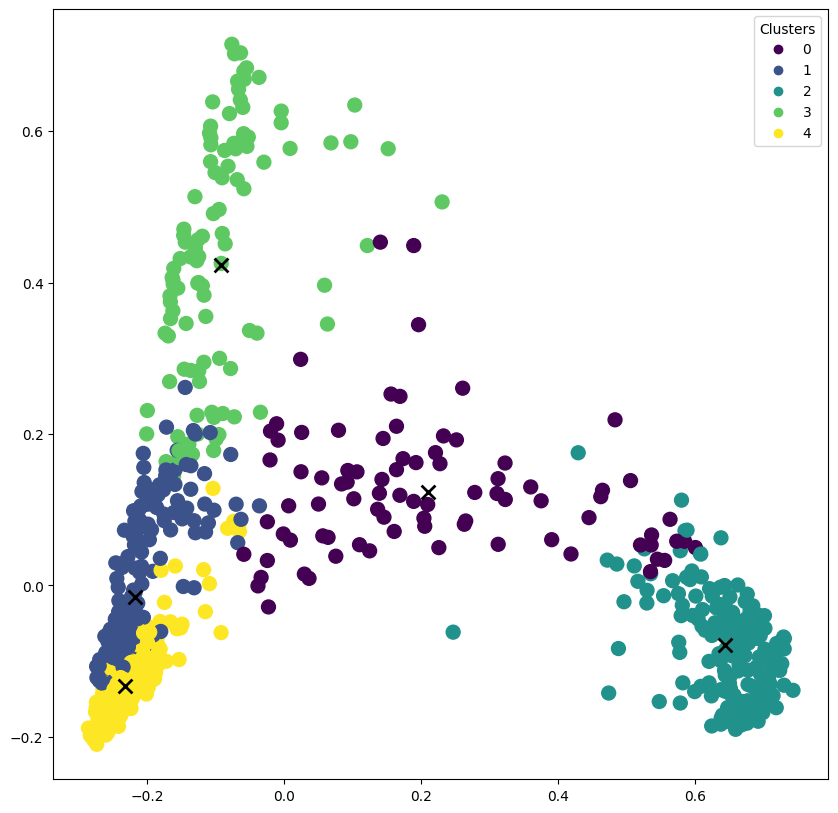

In [28]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Partie 2

# Word Embeddings : le modèle Word2Vec

## Imports

In [29]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

## Chargement et traitement des phrases du corpus

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [30]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [31]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrams

Article intéressant sur le sujet : https://towardsdatascience.com/word2vec-for-phrases-learning-embeddings-for-more-than-one-word-727b6cf723cf

In [32]:
bigram_phrases = Phrases(sentences)

L'object `phrases` peut être vu comme un large dictionnaire d'expressions multi-mots associées à un score, le *PMI-like scoring*. Ce dictionnaire est construit par un apprentissage sur base d'exemples.
Voir les références ci-dessous :
- https://arxiv.org/abs/1310.4546
- https://en.wikipedia.org/wiki/Pointwise_mutual_information

In [33]:
type(bigram_phrases.vocab)

dict

Il contient de nombreuses clés qui sont autant de termes observés dans le corpus

In [34]:
len(bigram_phrases.vocab.keys())

1834353

Prenons une clé au hasard :

In [35]:
key_ = list(bigram_phrases.vocab.keys())[144222]
print(key_)

o_belge


Le dictionnaire indique le score de cette coocurrence :

In [36]:
bigram_phrases.vocab[key_]

3

Lorsque l'instance de `Phrases` a été entraînée, elle peut concaténer les bigrams dans les phrases lorsque c'est pertinent.

### Conversion des `Phrases` en objet `Phraser`

`Phraser` est un alias pour `gensim.models.phrases.FrozenPhrases`, voir ici https://radimrehurek.com/gensim/models/phrases.html.

Le `Phraser` est une version *light* du `Phrases`, plus optimale pour transformer les phrases en concaténant les bigrams.

In [37]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

Le `Phraser` est un objet qui convertit certains unigrams d'une liste en bigrams lorsqu'ils ont été identifiés comme pertinents.

### Extraction des trigrams

Nous répétons l'opération en envoyant cette fois la liste de bigrams afin d'extraire les trigrams.

In [38]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [39]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [40]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [41]:
print(corpus[:100])

[['soixante', 'neuvi', '-', 'me', 'annee', 'm', '*', '227', 's', 'centimes', 'le', 'n', '"', 'samedi', '15_aout', '1914', ';\\-', 'de', 'gharlero', '-', 'r', '.', 'pour', 'la', 'belgique', '1', 'mois', '.'], ['i', '.', '23', '8', 'mois', ',', '3', '.', '00', 'e', 'mois', '.'], ['s', '.', 'oo', 'un', 'an', ',', '12', '.', '00', 'on', 's', "'", 'abonne', 'a', 'toute', 'epoque', 'de', 'l', "'", 'annee', '.'], ['remettre', 'an', 'facteur', 'it', 'montant', 'de', 'l', "'", 'abonnement', 'pour', 'recevoir', 'le', 'journal', 'a', 'la', 'prer', '.'], ['r', '.', 'xiere', 'distribution', 'du', 'matitti_vers', 'la', 'verite', 'par', 'la', 'scicnte', 'vers', 'la', 'liberte', 'par', 'le', 'droit', 'jc', 'PS', 'a', 'l', "'", 'egalite', 'par', 'la', 'jasild', 'a', 'l', "'", 'harmonie_sociale', 'par', 'la', 'fraternite', 'on', 'traite', 'a', 'forfait', 'pour', 'les', 'annonces', 'qui', 'doivent_etre', "'", 'plusieurs_fois_repetees', '.'], ['pour', 'les', 'annonces', 'de', 'bruxelles', 'et', 'de', 'l',

## Entrainement d'un modèle Word2Vec sur ce corpus

In [42]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: user 2min 6s, sys: 1.92 s, total: 2min 8s
Wall time: 59.2 s


#### Remarque

Vous voyez ici que l'entrainement du modèle est parallélisé (sur 4 workers).

Lors qu'on parallélise l'entrainement du modèle, 4 modèles "séparés" sont entrainés sur environ un quart des phrases.

Ensuite, les résultats sont agrégés pour ne plus faire qu'un seul modèle.

On ne peut prédire quel worker aura quelle phrase, car il y a des aléas lors de la parallélisation (p. ex. un worker qui serait plus lent, etc.).

Du coup, les valeurs peuvent varier légèrement d'un entrainement à l'autre.

Mais, globalement, les résultats restent cohérents.

### Sauver le modèle dans un fichier

In [43]:
outfile = f"../data/newspapers.model"
model.save(outfile)

## Explorer le modèle

### Charger le modèle en mémoire

In [44]:
model = Word2Vec.load("../data/newspapers.model")

### Imprimer le vecteur d'un terme

In [45]:
model.wv["anarchie"]

array([ 0.30065235, -0.93465024, -0.54136723, -0.78559387, -1.4900589 ,
       -0.539545  ,  0.9920579 ,  1.5105938 ,  0.39032438,  0.43067068,
        1.07895   , -0.18465959, -0.25191882,  0.13364293,  0.9131906 ,
       -0.7569822 ,  0.84702575,  0.45077372, -0.6293833 , -0.02843049,
        0.34285563, -0.37770227,  1.0958704 , -0.6722088 ,  0.35883126,
        0.1026409 ,  1.556489  , -0.36571348,  2.1204336 , -0.11399636,
       -0.11728401,  0.41145787], dtype=float32)

### Calculer la similarité entre deux termes

In [46]:
model.wv.similarity("imperialisme", "colonisation")

0.42119566

In [47]:
model.wv.similarity("revolution", "progres")

0.2416669

In [48]:
model.wv.similarity("conference", "exposition")

0.5749209

### Chercher les mots les plus proches d'un terme donné

In [49]:
model.wv.most_similar("politique", topn=10)

[('democratie', 0.8523953557014465),
 ('responsabilite', 0.8236656785011292),
 ('conquete', 0.822022557258606),
 ('diplomatie', 0.8207517862319946),
 ('puissance', 0.8194115161895752),
 ('neutralite', 0.8187387585639954),
 ('doctrine', 0.8155580759048462),
 ('classe_ouvriere', 0.8149206042289734),
 ('necessite', 0.8130574822425842),
 ('conciliation', 0.80666184425354)]

In [50]:
model.wv.most_similar("democratie", topn=10)

[('monarchie', 0.9201676845550537),
 ('classe_ouvriere', 0.8918178081512451),
 ('domination', 0.8727161884307861),
 ('conquete', 0.8655799627304077),
 ('diplomatie', 0.8644460439682007),
 ('neutralite', 0.8642774224281311),
 ('fraternite', 0.85494065284729),
 ('paix_generale', 0.8539274334907532),
 ('violation', 0.8530941605567932),
 ('politique', 0.852395236492157)]

In [51]:
model.wv.most_similar("justice", topn=10)

[('dignite', 0.8596799969673157),
 ('defense_nationale', 0.8382152915000916),
 ('neutralite', 0.8160256147384644),
 ('republique', 0.8138791918754578),
 ('liberte', 0.8071147203445435),
 ('nation_belge', 0.8020266890525818),
 ('sante', 0.7884956002235413),
 ('responsabilite', 0.7869990468025208),
 ('religion', 0.7761026620864868),
 ('patrie', 0.7616206407546997)]

### Faire des recherches complexes à travers l'espace vectoriel

In [52]:
print(model.wv.most_similar(positive=['alliance', 'paix'], negative=['liberte']))

[('entente', 0.7294784784317017), ('rupture', 0.7203816771507263), ('allemagne', 0.7180857062339783), ('conclusion', 0.7110905051231384), ('guerre_mondiale', 0.7046806812286377), ('ere', 0.7016835808753967), ('opposition', 0.7016750574111938), ('paix_separee', 0.7014725208282471), ('ukraine', 0.6997547745704651), ('affaire', 0.6982417702674866)]
